# Notebook 03 — Feature Engineering
Neste notebook iremos transformar os dados brutos em métricas úteis para o modelo
de clusterização.

As principais *features* calculadas serão:

- Retorno médio diário (`avg_return`)
- Volatilidade (`volatility`)
- Risco de queda (`downside_std`)
- Volume médio (`avg_volume`)
- Market cap médio (`avg_marketcap`)
- Transformações logarítmicas


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from src.features import compute_features

## Definição da Função de Cálculo de Features
Função que recebe o histórico de preços e calcula as principais métricas de risco e retorno para cada criptomoeda, considerando uma janela de dias definida.

In [28]:
def compute_features(price_history_df, lookback_days=30):
    from datetime import timedelta
    import numpy as np
    last_date = price_history_df['timestamp'].max()
    cutoff = last_date - timedelta(days=lookback_days)
    df_recent = price_history_df[price_history_df['timestamp'] >= cutoff].copy()
    features = []
    for coin, g in df_recent.groupby('coin'):
        g = g.sort_values('timestamp')
        g['ret'] = g['price'].pct_change()
        avg_return = g['ret'].mean(skipna=True)
        volatility = g['ret'].std(skipna=True)
        downside_std = g[g['ret'] < 0]['ret'].std(skipna=True)
        avg_volume = g['volume'].mean()
        avg_marketcap = g['market_cap'].mean()
        features.append({
            'coin': coin,
            'avg_return': avg_return,
            'volatility': volatility,
            'downside_std': downside_std,
            'avg_volume': avg_volume,
            'avg_marketcap': avg_marketcap
        })
    df_feat = pd.DataFrame(features).set_index("coin")
    df_feat = df_feat.fillna(0)
    return df_feat

## Carregamento dos Dados
Importa o dataset gerado na etapa de coleta, preparando os dados para o cálculo das features de risco e retorno.

In [29]:
df = pd.read_csv("../data/raw/prices_raw.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,price,volume,market_cap,coin
0,2025-09-30 17:01:29.261,112843.613034,5.532786e+10,2.248248e+12,bitcoin
1,2025-09-30 18:02:02.079,113343.475429,5.558492e+10,2.259015e+12,bitcoin
2,2025-09-30 19:02:18.018,113644.471873,5.554536e+10,2.264727e+12,bitcoin
3,2025-09-30 20:02:25.069,114491.910339,5.674079e+10,2.278936e+12,bitcoin
4,2025-09-30 21:02:37.088,114618.579149,5.744427e+10,2.284540e+12,bitcoin


## Cálculo das Features de Risco e Retorno
Aplica a função de cálculo sobre o dataset, gerando as métricas que serão utilizadas na etapa de clusterização.

In [30]:
features = compute_features(df, lookback_days=30)
features

,avg_return,volatility,downside_std,avg_volume,avg_marketcap
coin,,,,,
aerodrome-finance,-0.000397,0.015961,0.009540,7.919392e+07,7.820041e+08
bitcoin,-0.000225,0.005388,0.004168,7.383754e+10,1.941471e+12
chainlink,-0.000307,0.009729,0.007381,8.180427e+08,1.009109e+10
ethena,-0.000395,0.012771,0.008882,2.867441e+08,2.222000e+09
ethereum,-0.000286,0.008203,0.006338,3.254722e+10,3.930922e+11
kamino,0.000029,0.010988,0.007400,2.154812e+07,1.889178e+08
lido-dao,-0.000274,0.011777,0.008553,8.225579e+07,6.664344e+08
pendle,-0.000074,0.012029,0.008140,5.777964e+07,4.321747e+08
solana,-0.000373,0.009166,0.007162,6.163714e+09,8.372059e+10


## Estatísticas das Features Calculadas
Apresenta estatísticas descritivas das métricas geradas, permitindo avaliar a distribuição e variabilidade das features entre as criptomoedas.

In [31]:
features.describe()

,avg_return,volatility,downside_std,avg_volume,avg_marketcap
count,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01
mean,-0.000260,0.011393,0.007813,1.141492e+10,2.433459e+11
std,0.000139,0.003652,0.001782,2.414568e+10,6.090772e+11
min,-0.000397,0.005388,0.004168,2.154812e+07,1.889178e+08
25%,-0.000357,0.009307,0.007217,7.995939e+07,6.953268e+08
50%,-0.000293,0.011383,0.007770,2.709498e+08,1.507511e+09
75%,-0.000237,0.012585,0.008800,4.827296e+09,6.531322e+10
max,0.000029,0.017922,0.010562,7.383754e+10,1.941471e+12


## Visualizações das Features
Gráficos que mostram a distribuição das métricas calculadas, facilitando a identificação de padrões, outliers e diferenças entre os ativos.

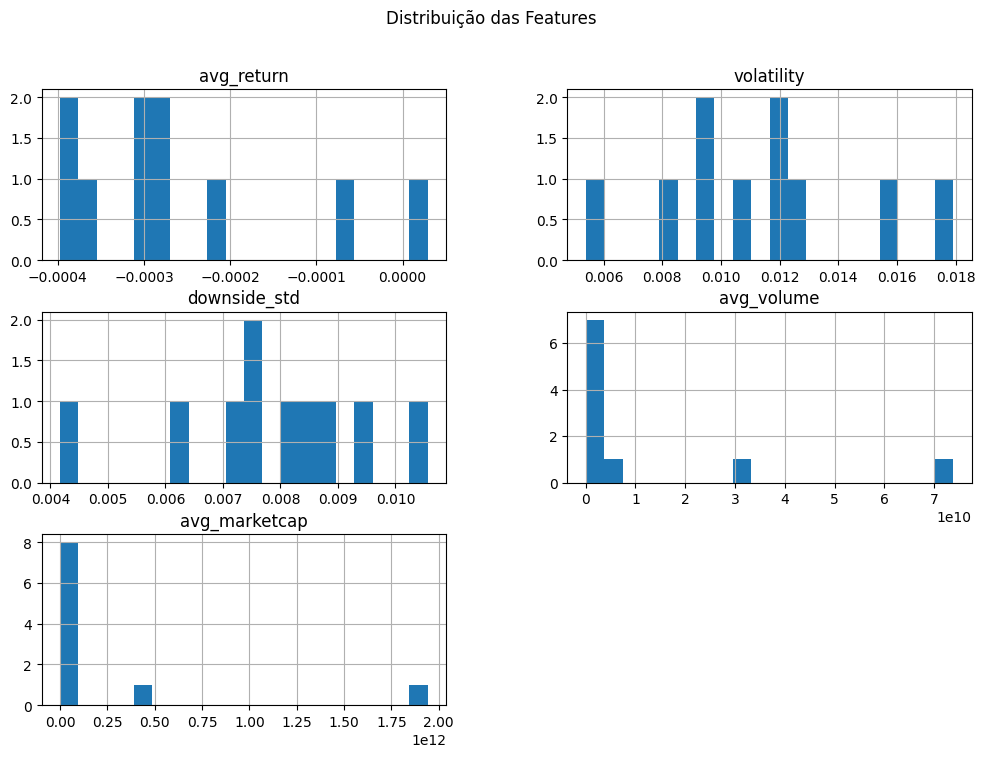

In [32]:
features.hist(figsize=(12,8), bins=20)
plt.suptitle("Distribuição das Features")
plt.show()

## Transformações Adicionais nas Features
Aplica transformações logarítmicas e normalizações para melhorar a qualidade das métricas e facilitar a modelagem dos dados nas etapas seguintes.

In [33]:
# evolução recente do risco (retorno absoluto)
features["abs_return"] = features["avg_return"].abs()

# volume log-normalizado
features["log_volume"] = np.log1p(features["avg_volume"])
features["log_volume"] = features["log_volume"] / features["log_volume"].max()

# market cap log
features["log_mc"] = np.log1p(features["avg_marketcap"])

## Salvamento do Dataset Processado
Exporta o DataFrame final de features para um arquivo CSV, permitindo seu uso na etapa de clusterização e modelagem.

In [34]:
output_path = "../data/processed/crypto_features.csv"
features.to_csv(output_path)

print("Arquivo salvo em:", output_path)
features

Arquivo salvo em: ../data/processed/crypto_features.csv


,avg_return,volatility,downside_std,avg_volume,avg_marketcap,abs_return,log_volume,log_mc
coin,,,,,,,,
aerodrome-finance,-0.000397,0.015961,0.009540,7.919392e+07,7.820041e+08,0.000397,0.726766,20.477371
bitcoin,-0.000225,0.005388,0.004168,7.383754e+10,1.941471e+12,0.000225,1.000000,28.294467
chainlink,-0.000307,0.009729,0.007381,8.180427e+08,1.009109e+10,0.000307,0.820073,23.034919
ethena,-0.000395,0.012771,0.008882,2.867441e+08,2.222000e+09,0.000395,0.778182,21.521673
ethereum,-0.000286,0.008203,0.006338,3.254722e+10,3.930922e+11,0.000286,0.967266,26.697310
kamino,0.000029,0.010988,0.007400,2.154812e+07,1.889178e+08,0.000029,0.674754,19.056823
lido-dao,-0.000274,0.011777,0.008553,8.225579e+07,6.664344e+08,0.000274,0.728282,20.317452
pendle,-0.000074,0.012029,0.008140,5.777964e+07,4.321747e+08,0.000074,0.714168,19.884341
solana,-0.000373,0.009166,0.007162,6.163714e+09,8.372059e+10,0.000373,0.900772,25.150751
